<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/CNN_LSTM_optimiserhuber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

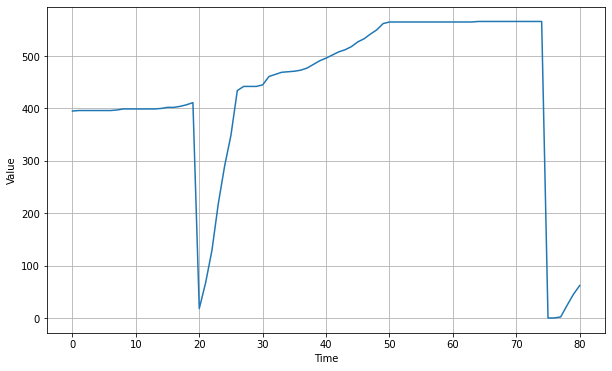

In [4]:
import csv
time_step = []
temps = []

with open('/content/ευδαπ_dataset_527085.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

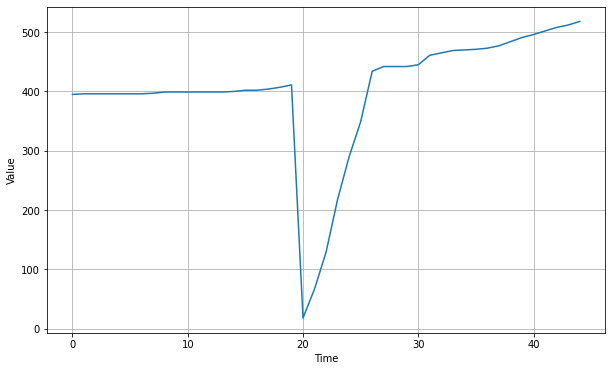

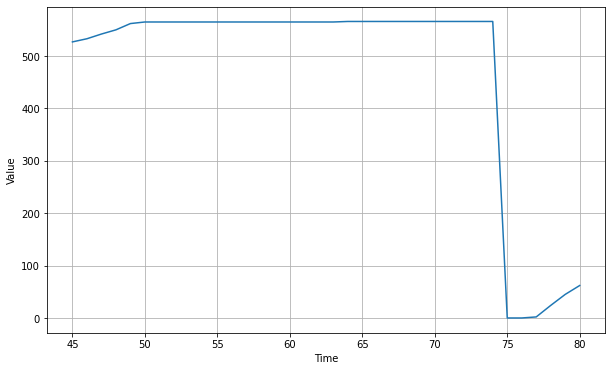

In [6]:
split_time = 45
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 3
batch_size = 2
shuffle_buffer_size = 3
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

diffrent windowing since we use CNN

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 415.9748 - mae: 416.4748
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 415.9128 - mae: 416.4128
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 415.7867 - mae: 416.2867
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 415.5933 - mae: 416.0933
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 415.3274 - mae: 415.8274
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 414.9819 - mae: 415.4819
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 414.5464 - mae: 415.0464
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 414.0069 - mae: 414.5069
Epoch 9/100
1/1 [==============================] - 0s 22ms/step - loss: 413.3429 - mae: 413.8429
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 412.5245 - mae: 413.0245
Epoch 11/100
1/1 [===========

(1e-08, 0.0001, 0.0, 200.0)

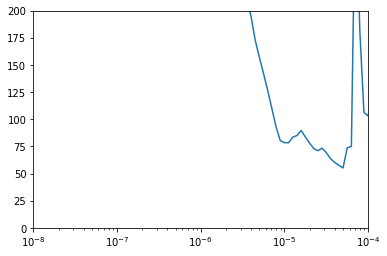

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 200])

try to change batch size

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=6e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
8/8 [==============================] - 2s 6ms/step - loss: 236.7998 - mae: 237.2998
Epoch 2/500
8/8 [==============================] - 0s 5ms/step - loss: 107.1801 - mae: 107.6775
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 158.1670 - mae: 158.6669
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 116.2715 - mae: 116.7715
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 75.1762 - mae: 75.6716
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 70.7599 - mae: 71.2573
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 89.5820 - mae: 90.0790
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 79.4441 - mae: 79.9391
Epoch 9/500
8/8 [==============================] - 0s 6ms/step - loss: 77.4611 - mae: 77.9611
Epoch 10/500
8/8 [==============================] - 0s 5ms/step - loss: 88.0195 - mae: 88.5162
Epoch 11/500
8/8 [==============================] -

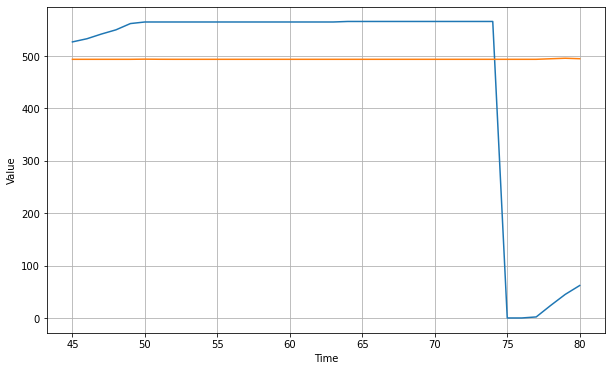

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

135.2993

<Figure size 432x288 with 0 Axes>

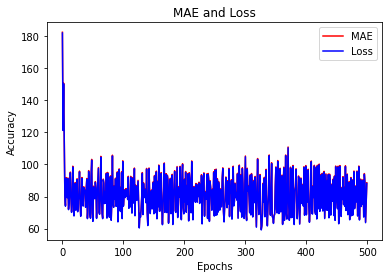

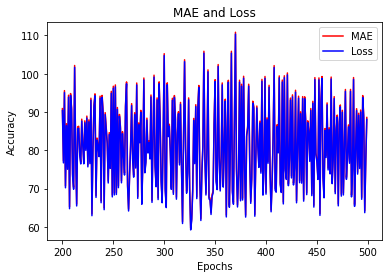

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()